# **PushBlockEnv Reinforcement Learning**

### **Imports**

In [29]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Torch
import torch
from torch import nn
from torch import optim
### Torch RL
# Env
from torchrl.envs.libs import UnityMLAgentsEnv
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from torchrl.envs.utils import step_mdp, check_env_specs
from torchrl.envs import TransformedEnv, Stack, ExcludeTransform, CatTensors, AutoResetTransform

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement


# Model
from model import create_policy, create_value
# Train Util
from train_util import make_loss_module, compute_trajectory_metrics, loss_dict, Stopwatch, Logger, Checkpointer, compute_single_trajectory_metrics, load_model
# Inspect Results
from result import plot, play, test

from config import (
    ENV_PATH,
    CKPT_PATH, LOG_PATH, MODEL_PATH, RESULTS_PATH,
    LOG_KEYS, LOG_INDEX, BEST_METRIC_KEY,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Create Torch Env**

In [36]:
# Unity autoresets, individual agent resets don't work, they restart the environment, make agent resets no ops
class SoftResetUnityEnv(UnityMLAgentsEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._did_first_reset = False
        self._last_base_td = None  # cache last

    def _step(self, tensordict):
        # cache last
        self._last_base_td = tensordict
        return super()._step(tensordict)

    def _reset(self, tensordict=None, **kwargs):
        hard = kwargs.pop("hard", False)
        if hard or not self._did_first_reset:
            # Real Unity reset
            td = super()._reset(tensordict, **kwargs)
            self._did_first_reset = True
            self._last_base_td = td  # cache last
            return td

        # Soft reset: DON'T touch Unity. Give base td (unity auto resets)
        base_td = self._last_base_td
        return self._make_td_out(base_td, is_reset=True)


def create_unity_env(graphics=False, **kwargs):
    try:
        env.close()
    except:
        pass
    from torchrl.envs.libs import UnityMLAgentsEnv # Force load
    
    def _create_env():
        env = TransformedEnv(SoftResetUnityEnv(
            file_name=ENV_PATH, worker_id=np.random.randint(10000), 
            no_graphics=(not graphics), **kwargs,
            device="cpu",
        ))
        return env
    
    ATTEMPTS = 10
    for i in range(ATTEMPTS):
        try:
            env = _create_env()
            break
        except:
            pass
        if i + 1 == ATTEMPTS: raise RuntimeError("Failed to load environment")

    return env

def batch_agents(env, out_key="agents"):
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    
    # Create transform
    stack = Stack(
        in_keys=[(agent_root_key, agent) for agent in agents], 
        out_key=(out_key,), 
        in_key_inv=(out_key,), 
        out_keys_inv=[(agent_root_key, agent) for agent in agents]
    )

    env.append_transform(stack)
    return env

def create_base_env(graphics=False, **kwargs):
    env = create_unity_env(graphics, **kwargs)

    # Batch into Agents Dimension
    env = batch_agents(env)

    # Concatenate Observation
    obs_keys = env.observation_keys
    env.append_transform(
        CatTensors(in_keys=obs_keys, out_key=("agents", "observation"), del_keys=False)
    )
    # Exclude Group Reward
    env.append_transform(
        ExcludeTransform(("agents", "group_reward"))
    )
    return env

def create_env(graphics=False, time_scale = 1, **kwargs):
    # Time scale
    if time_scale != 1:
        engine_config_channel = EngineConfigurationChannel()
        env = create_base_env(graphics, **kwargs, side_channels=[engine_config_channel])
        engine_config_channel.set_configuration_parameters(time_scale=time_scale)
    else:
        env = create_base_env(graphics, **kwargs)

    return env

### **Inspect Specs**

In [16]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_env(time_scale=20, graphics=False)
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [17]:
action_key = env.action_key[1]
print(f"action_key: {action_key}")

observation_shape = env.observation_spec["agents", "observation"].shape
action_shape = env.action_spec["agents", action_key].shape

print(f"observation_shape: {observation_shape}, action_shape: {action_shape}")

action_key: discrete_action
observation_shape: torch.Size([24, 444]), action_shape: torch.Size([24, 11])


In [18]:
td = env.rollout(10, break_when_any_done=False)
td

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        agents: TensorDict(
            fields={
                StackingSensor_size6_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([1000, 24, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                StackingSensor_size6_RayPerceptionSensor: Tensor(shape=torch.Size([1000, 24, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                StackingSensor_size6_VectorSensor_size4: Tensor(shape=torch.Size([1000, 24, 24]), device=cpu, dtype=torch.float32, is_shared=False),
                discrete_action: Tensor(shape=torch.Size([1000, 24, 11]), device=cpu, dtype=torch.int32, is_shared=False),
                done: Tensor(shape=torch.Size([1000, 24, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([1000, 24, 444]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([1000, 24, 1]), device=cpu, dtype=torch.bool, is_shared=False)

### **Inspect Action Space**

We have categorical actions: 7 choices (choose one).

In [25]:
actions_df = pd.DataFrame({
    "action": td["agents", action_key].reshape(-1)
})
actions_df.describe()

,action
count,264000.000000
mean,0.363636
std,0.481047
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### **Inspect Observation Space**

Observations consist of binary features and continuous features scaled to the range [0, 1].

In [20]:
obs_df = pd.DataFrame({
    "obs": td["agents", "observation"].reshape(-1)
})
obs_df.describe()

,obs
count,1.065600e+07
mean,3.443362e-01
std,4.740472e-01
min,-5.375397e-01
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,1.000000e+00


### **Inspect Reward Space**
-1 for jumping off, -0.0025 for surviving, +1 on success. And other values??

In [21]:
reward_df = pd.DataFrame({
    "reward": td["next", "agents", "reward"].reshape(-1),
})
reward_df.describe()

,reward
count,24000.000000
mean,-0.014267
std,0.111661
min,-1.000000
25%,-0.002500
50%,-0.002500
75%,-0.002000
max,1.000000


In [23]:
reward_df.value_counts()

reward 
-0.0025    17633
 0.0000     5802
-1.0000      301
-0.0020       74
-0.0010       69
-0.0005       64
-0.0015       54
 1.0000        3
Name: count, dtype: int64

## **Create Models**

### **Config**

In [26]:
HIDDEN_DIM = 256
N_BLOCKS = 3

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": int(observation_shape[1]),
    "out_features": int(action_shape[1]),
}
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 3, 'in_features': 444, 'out_features': 11}

### **Inspect**

In [27]:
policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

with torch.no_grad():
    td = env.rollout(10, policy=policy, auto_cast_to_device=True).to(device)
    loss_module.value_estimator(td)
data = step_mdp(td)["agents"]
data

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        StackingSensor_size6_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([10, 24, 210]), device=cpu, dtype=torch.float32, is_shared=False),
        StackingSensor_size6_RayPerceptionSensor: Tensor(shape=torch.Size([10, 24, 210]), device=cpu, dtype=torch.float32, is_shared=False),
        StackingSensor_size6_VectorSensor_size4: Tensor(shape=torch.Size([10, 24, 24]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([10, 24, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        discrete_action: Tensor(shape=torch.Size([10, 24, 11]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 24, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        log_prob: Tensor(shape=torch.Size([10, 24]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([10, 24, 11]), device=cpu, dtype=torch.float32, is_shared=False),
        observa

In [28]:
compute_single_trajectory_metrics(td)

{'return': -0.024895833805203438,
 'episode_length': 10.0,
 'entropy': 2.226991653442383}

## **Training**

### **Train Config**

In [30]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

### Training Loop Params
WORKERS = os.cpu_count() // 2
print("device:", device, "workers:", WORKERS)
STORAGE_DEVICE = device
GENERATION_SIZE = 1000 * WORKERS # 1000 is the truncation point for the env
TIMESTAMPS = GENERATION_SIZE * 100
EPOCHS = 5

# GD Params
MINIBATCH_SIZE = 64
LR = 5e-5
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params
TIME_SCALE = 20

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-5

NAME = 'run0'

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1

CONTINUE=True

device: cpu workers: 7


### **Train Loop**

In [37]:
def train(create_env, policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
    

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            update_at_each_batch=True,
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
        )
    replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)


    ### TRAINING LOOP
    short_watch.start(); long_watch.start()
    policy.eval(); value.eval()
    for i, tensordict_data in enumerate(collector):
        # 0. Time collect
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})

        # 1. Compute Advantages and Value Target and Metrics
        tensordict_data = tensordict_data.to(device)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)
            metrics = compute_trajectory_metrics(tensordict_data)
        logger.add(metrics)

        # 2. Minibatch Gradient Descent Loop
        short_watch.start()
        policy.train(); value.train()
        replay_buffer.empty(); replay_buffer.extend(tensordict_data.reshape(-1))
        for epoch in range(EPOCHS):
            for j, batch in enumerate(replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(loss_dict(loss_data, weight))
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 3. Log results
        logger.sum({"generation": 1})
        logger.sum({"timestep": GENERATION_SIZE})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        # 4. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[BEST_METRIC_KEY]
            checkpointer.save_progress(metric_key=BEST_METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                BEST_METRIC_KEY: metric,
            })

        # 5. Start collection time
        short_watch.start()

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [ ]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

train(lambda: create_env(time_scale=TIME_SCALE), policy, value, timestamps=TIMESTAMPS)

FAILED TO READ LOG FILE, STARTING FROM SCRATCH.
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-s

## **Test**

Thread 0x16da1f000 may have been prematurely finalized
Thread 0x16f7a3000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Setting up 7 worker threads for Enlighten.
Thread 0x16e433000 may have been prematurely finalized
Thread 0x16e31b000 may have been prematurely finalized
Thread 0x16e3a7000 may have been prematurely finalized
Thread 0x16e177000 may have been prematurely finalized
Thread 0x16e28f000 may have been prematurely finalized
Thread 0x16e203000 may have been prematurely finalized
Thread 0x16c47f000 may have been prematurely finalized
Thread 0x16c50b000 may have been prematurely finalized
Thread 0x16c597000 may have been prematurely finalized
Thread 0x16c623000 may have been prematurely finalized
Thread 0x16c6af000 may have been prematurely finalized
Thread 0x16c73b000 may have been prematurely finalized
Thread 0x16c7c7000 may have been prematurely finalized
Thread 0x16d293000 may have been prematurely finalized
Setting up 7 worker threads for En

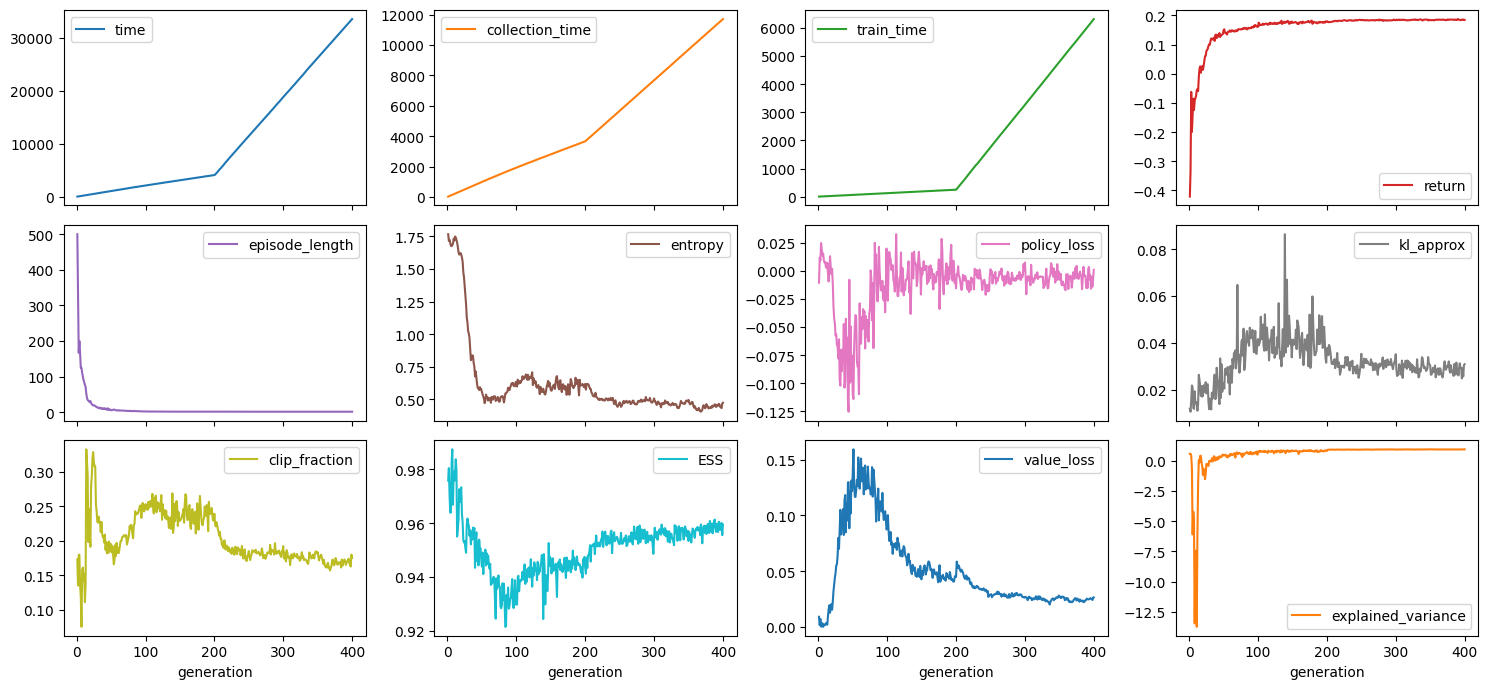

In [113]:
plot('run1')

In [109]:
policy = create_policy(MODEL_CONFIG).to(device)
path = os.path.join(MODEL_PATH, f"run1.pt")
model_states = torch.load(path, map_location=torch.device('cpu'))
policy.load_state_dict(model_states["policy_state_dict"])

<All keys matched successfully>

In [111]:
env = create_env(graphics=True)

tensordict_data = None
with torch.no_grad():
    tensordict_data = env.rollout(1000, policy=policy, auto_cast_to_device=True, break_when_any_done=False).to(device)
    env.close()
    metrics = compute_single_trajectory_metrics(tensordict_data)

metrics

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

UnityCommunicatorStoppedException: Communicator has exited.

In [34]:
tensordict_data

TensorDict(
    fields={
        agents: LazyStackedTensorDict(
            fields={
                StackingSensor_size3_OffsetRayPerceptionSensor: Tensor(shape=torch.Size([1000, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                StackingSensor_size3_RayPerceptionSensor: Tensor(shape=torch.Size([1000, 32, 105]), device=cpu, dtype=torch.float32, is_shared=False),
                discrete_action: Tensor(shape=torch.Size([1000, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([1000, 32, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                log_prob: Tensor(shape=torch.Size([1000, 32]), device=cpu, dtype=torch.float32, is_shared=False),
                logits: Tensor(shape=torch.Size([1000, 32, 7]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([1000, 32, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                termin

In [36]:
tensordict_data["next", "agents", "done"].sum()

tensor(3)